# Text detection from images using EasyOCR

In [5]:
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
import datetime
from contextlib import closing
import configparser
import ast,re
import warnings
warnings.filterwarnings("ignore")
import pymsteams
from datetime import timedelta
from azure.storage.blob import BlockBlobService,PublicAccess
import io#convert data into text.
import azure.functions as func
import pyodbc,pandas as pd
from sqlalchemy import create_engine, event
from sqlalchemy.engine.url import URL

# Reading images

In [6]:
path = "C:\\OCR_PROJECT\\ImageData\\BankCard\\"
#path = "C:\\Users\\RAD-Anil Sonker\\Documents\\OCR_PROJECT\\ImageData\\Raleigh Documents\\"

In [7]:
IMAGE_PATH = path+"adhar_card_anil.jpeg"
IMAGE_PATH

'C:\\OCR_PROJECT\\ImageData\\BankCard\\adhar_card_anil.jpeg'

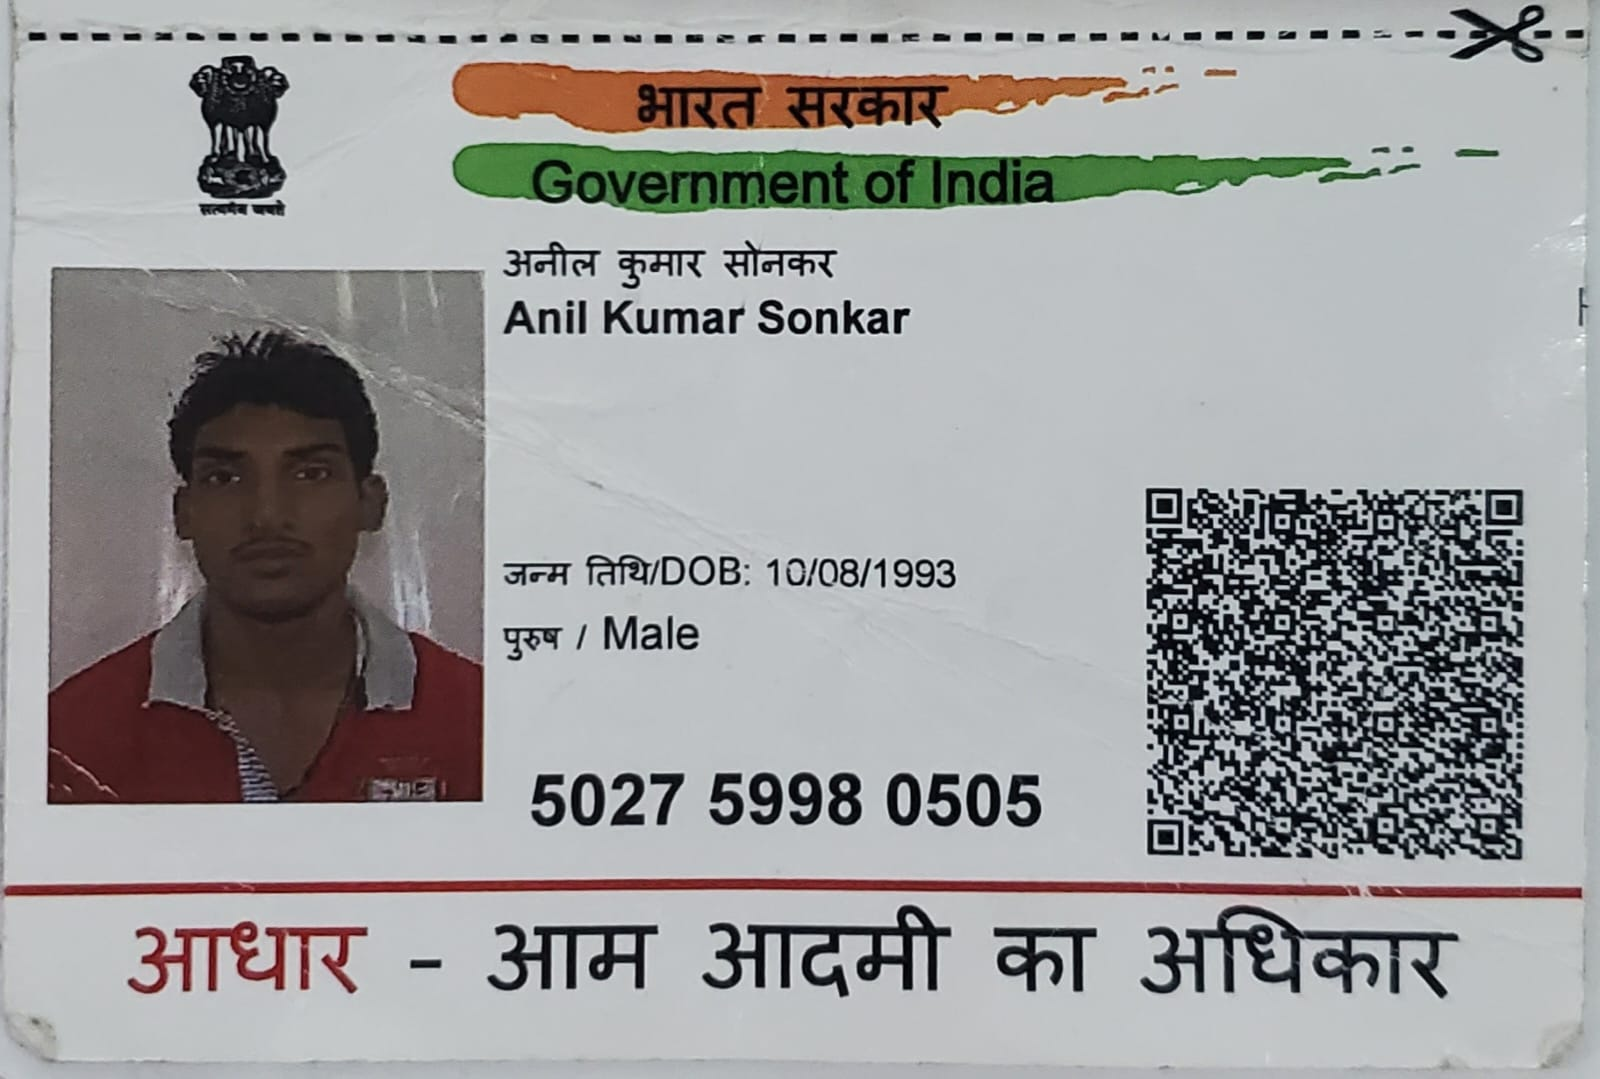

In [8]:
from IPython.display import Image
Image(filename=IMAGE_PATH)

In [9]:
ocrreader = easyocr.Reader(['en'],gpu=True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [10]:
result = ocrreader.readtext(IMAGE_PATH,detail=1)
dict_data =[]
for item in result:
    if item[2]>=0.10:
        dict_data.append({"value":str(item[1]).replace("#","").replace("[","I").replace("]","I"),"confidence":item[2]})

# most probable text from the image

In [11]:
dict_data

[{'value': 'HRT HeR', 'confidence': 0.4387863024892087},
 {'value': 'Government of India', 'confidence': 0.8180530518493405},
 {'value': 'Anil Kumar Sonkar', 'confidence': 0.9219681618565267},
 {'value': 'T4 A@IDOB: 10/08/1993', 'confidence': 0.39827983685371693},
 {'value': 'Male', 'confidence': 0.9999982714653015},
 {'value': '5027 5998 0505', 'confidence': 0.8414552707967414},
 {'value': '31YR', 'confidence': 0.1363614797592163},
 {'value': '314  31adi} &T 3fea', 'confidence': 0.1262084874190037}]

# adhar card details processing

In [12]:

adhar_number  = []
date_of_birth = []

adhar_holder   = ""
adhar_holder_address = " "
index_for_name = []
index_for_address = []
state_name = ['andhra pradesh','arunachal pradesh','assam','bihar','chhattisgarh','goa','gujarat','haryana','himachal pradesh',
'jammu & kashmir','jharkhand','karnataka','kerala','madhya pradesh','maharashtra','manipur','meghalaya','mizoram',
 'nagaland','odisha (orissa)','punjab','rajasthan','sikkim','tamil nadu','telangana','tripura','uttar pradesh',
 'uttarakhand','west bengal']

for idx,item in enumerate(dict_data):
    item = item.get('value',None)
    #item = str(item).replace('I',"/")
    if (len(item)==4) & (item.isdigit()==True):
        adhar_number.append(str(item).strip())#.replace(" ",""))
                          
    elif (len(item)>4 ) & ("".join(item.split(" ")).isdigit()==True):
        adhar_number.append(str(item))#.replace(" ",""))
    elif ("/" in item) & (len(item)>=4):
        index_for_name.append(idx-1)
        print(idx-1)
        date_of_birth.append(str(item).replace(" ",""))#5
        
    elif "address" in str(item).lower():
        index_for_address.append(idx+2)
    elif any(state in str(item).lower() for state in state_name):
        index_for_address.append(idx)

#adhar number 
print("adhar number list :",adhar_number)
if len(adhar_number)>0:
    #adhar_number = adhar_number[0:4]
    adhar_number = " ".join(adhar_number)
    print(adhar_number)
#Name of adhar holder
if len(index_for_name)>0:
    adhar_holder = dict_data[index_for_name[-1]].get("value","").strip()

#date of birth
print("date of birth :",date_of_birth)
if len(date_of_birth)==1:
    date_of_birth = str(date_of_birth[0])[-10:]
elif len(date_of_birth)>1:
    date_of_birth = str(date_of_birth[-1])[-10:]
else:
    date_of_birth = ""

#Address of aadhar holder
if len(index_for_address)>0:
    index_for_address_list = [i for i in range(index_for_address[0],index_for_address[-1]+1)]
    for addid in index_for_address_list:
        adhar_holder_address =  adhar_holder_address + str(dict_data[addid].get("value","").strip())
        
    print("Address :",adhar_holder_address.strip())
    
adhar_card_details = {"AdharNumber":adhar_number,"AdharHolder":adhar_holder,"DateofBirth":date_of_birth}

adhar_card_details.update({"Address":adhar_holder_address.strip()})

2
adhar number list : ['5027 5998 0505']
5027 5998 0505
date of birth : ['T4A@IDOB:10/08/1993']


In [13]:
adhar_card_details

{'AdharNumber': '5027 5998 0505',
 'AdharHolder': 'Anil Kumar Sonkar',
 'DateofBirth': '10/08/1993',
 'Address': ''}

# extract the details by 

In [14]:
def find_final_expiry_date_string(date_string):
    non_decimal = re.compile(r'[^\d.]+')
    date_string = date_string.split("/")
    final_string =[]
    for item in date_string:
        final_string.append(non_decimal.sub('', item))
        
    final_string = "/".join(final_string)
    return final_string       

# try here and correct function 

In [15]:
card_number = []
expiry_date = []
card_holder = ""
card_issuer = ""
index_for_name = []
for idx,item in enumerate(dict_data):
    item = item.get('value',None)
    #item = str(item).replace('I',"/")
    if (len(item)==4) & (item.isdigit()==True):
        card_number.append(str(item).strip())#.replace(" ",""))
                          
    elif (len(item)>4 ) & ("".join(item.split(" ")).isdigit()==True):
        card_number.append(str(item))#.replace(" ",""))
    elif ("/" in item) & (len(item)>=4):
        index_for_name.append(idx+1)
        print(idx+1)
        expiry_date.append(str(item).replace(" ","").replace("'","")[-5:])#5

#for card number 
print("card number list :",card_number)
if len(card_number)>4:
    card_number = card_number[0:4]
    card_number_new =[]
    for item in card_number:
        item = str(item).replace(" ","")
        card_number_new.append(item)
    card_number = " ".join(card_number_new)
    print(card_number)
    
elif (len(card_number)>=1) & (len(card_number)<4):
    card_number = " ".join(card_number)
    card_number_new = card_number.split(" ")
    if len(card_number_new)>4:
        card_number_new = card_number_new[0:4]
        card_number = " ".join(card_number_new)
    print(card_number)

elif (len(card_number)==4):
    card_number_new =[]
    for item in card_number:
        item = str(item).replace(" ","")
        card_number_new.append(item)
    card_number = " ".join(card_number_new)
    print(card_number)

#for expiry date
print("expiry date list :",expiry_date)
if len(expiry_date)==1:
    expiry_date = expiry_date[0]
elif len(expiry_date)>1:
    expiry_date = expiry_date[-1]
else:
    expiry_date = ""
#for Card Holder     
if len(index_for_name)>0:
    if not str(dict_data[index_for_name[-1]].get('value',None)).replace(",","").replace(" ","").isdigit():#after date part any digit found index will get update
        index_for_name_ = index_for_name[-1]
    else:
        index_for_name_ = index_for_name[-1]+1
        
    avoid_string = ['american','express','american express','thru']   
    if str(dict_data[index_for_name_].get('value',None)).lower() in avoid_string:
        index_for_name_ = index_for_name_+1
        print(index_for_name_)
        
    card_holder_1 = dict_data[index_for_name_].get('value',None).upper()
    card_holder = str(card_holder_1).replace(".","").strip()# if found ex: 'G .'
    if (" " not in str(card_holder)) & (len(dict_data)>index_for_name_+1):
        card_holder = card_holder_1 + " " + dict_data[index_for_name_+1].get('value',None).upper()
        print("card holder :",card_holder)
#-------------------updated values after processed------------------------           
card_holder = str(card_holder).strip().replace(' .',".") #if found   
card_issuer = str(dict_data[0].get('value',None)).replace('$',"S")
if card_issuer.replace(" ","").isdigit():
    card_issuer = str(dict_data[-1].get('value',None))
    
expiry_date = find_final_expiry_date_string(expiry_date)#remove aplpha char if found
bank_card_details = {"CardNumber":card_number,"ExpiryDate":expiry_date,"CardHolder":card_holder,"CardIssuer":card_issuer}

4
card number list : ['5027 5998 0505']
5027 5998 0505
expiry date list : ['/1993']
card holder : MALE 5027 5998 0505


In [16]:
bank_card_details

{'CardNumber': '5027 5998 0505',
 'ExpiryDate': '/1993',
 'CardHolder': 'MALE 5027 5998 0505',
 'CardIssuer': 'HRT HeR'}

In [17]:
dict_data[index_for_name[-1]+1].get('value')

'5027 5998 0505'

# function based finding 

In [18]:
def easy_ocr_extract_card_detail(ocr_readr,local_file_path):
    try:
        result = ocr_readr.readtext(local_file_path)
        dict_data =[]
        for item in result:
            if item[2]>=0.10:
                dict_data.append({"value":str(item[1]).replace("#","").replace("[","I").replace("]","I"),"confidence":item[2]})
        #-------------------------------------rule based process-----------------------
        card_number = []
        expiry_date = []
        card_holder = ""
        card_issuer = ""
        index_for_name = []
        for idx,item in enumerate(dict_data):
            item = item.get('value',None)
            #item = str(item).replace('I',"/")
            if (len(item)==4) & (item.isdigit()==True):
                card_number.append(str(item))#.replace(" ",""))

            elif (len(item)>4 ) & ("".join(item.split(" ")).isdigit()==True):
                card_number.append(str(item))#.replace(" ",""))
            elif ("/" in item) & (len(item)>=4):
                index_for_name.append(idx+1)
                print(idx+1)
                expiry_date.append(str(item).replace(" ","").replace("'","")[-5:])#5

        #for card number 
        if len(card_number)>4:
            card_number = card_number[0:4]
            card_number = " ".join(card_number)
            print(card_number)
            
        elif (len(card_number)>=1) & (len(card_number)<=4):
            card_number = " ".join(card_number)
            card_number_new = card_number.split(" ")
            if len(card_number_new)>4:
                card_number_new = card_number_new[0:4]
                card_number = " ".join(card_number_new)
            print(card_number)

        #for expiry date
        if len(expiry_date)==1:
            expiry_date = expiry_date[0]
        elif len(expiry_date)>1:
            expiry_date = expiry_date[-1]
        else:
            expiry_date = ""
        #for Card Holder     
        if len(index_for_name)>0:
            if not dict_data[index_for_name[-1]].get('value',None).isdigit():#after date part any digit found index will get update
                index_for_name_ = index_for_name[-1]
            else:
                index_for_name_ = index_for_name[-1]+1
            
            avoid_string = ['american','express','american express']
            if str(dict_data[index_for_name_].get('value',None)).lower() in avoid_string:
                index_for_name_ = index_for_name_+1
                print(index_for_name_)
                
            card_holder_1 = dict_data[index_for_name_].get('value',None).upper()
            card_holder = str(card_holder_1).replace(".","").strip()# if found ex: 'G .'
            if (" " not in str(card_holder)) & (len(dict_data)>index_for_name_+1):
                card_holder = card_holder_1 + " " + dict_data[index_for_name_+1].get('value',None).upper()
        #-------------------updated values after processed------------------------
        card_holder = str(card_holder).strip().replace(' .',".") #if found 
        card_issuer = str(dict_data[0].get('value',None)).replace('$',"S")
        expiry_date = find_final_expiry_date_string(expiry_date)#remove aplpha char if found
        
        bank_card_details = {"CardNumber":card_number,"ExpiryDate":expiry_date,"CardHolder":card_holder,"CardIssuer":card_issuer}
        return bank_card_details
    except Exception as e:
        error_mess = "Error in easy_ocr_extract_card_detail :" +str(e)
        print(error_mess)
        return {"CardNumber":"","ExpiryDate":"","CardHolder":"","CardIssuer":""}

# Adhar card Detail Extract 

In [19]:
def easy_ocr_extract_adhar_card_detail(ocr_readr,local_file_path):
    try:
        result = ocr_readr.readtext(local_file_path)
        dict_data =[]
        for item in result:
            if item[2]>=0.10:
                dict_data.append({"value":str(item[1]).replace("#","").replace("[","I").replace("]","I"),"confidence":item[2]})
        #-------------------------------------rule based process-----------------------
        adhar_number  = []
        date_of_birth = []

        adhar_holder   = ""
        adhar_holder_address = " "
        index_for_name = []
        index_for_address = []
        state_name = ['andhra pradesh','arunachal pradesh','assam','bihar','chhattisgarh','goa','gujarat','haryana','himachal pradesh',
        'jammu & kashmir','jharkhand','karnataka','kerala','madhya pradesh','maharashtra','manipur','meghalaya','mizoram',
         'nagaland','odisha (orissa)','punjab','rajasthan','sikkim','tamil nadu','telangana','tripura','uttar pradesh',
         'uttarakhand','west bengal']

        for idx,item in enumerate(dict_data):
            item = item.get('value',None)
            #item = str(item).replace('I',"/")
            if (len(item)==4) & (item.isdigit()==True):
                adhar_number.append(str(item).strip())#.replace(" ",""))

            elif (len(item)>4 ) & ("".join(item.split(" ")).isdigit()==True):
                adhar_number.append(str(item))#.replace(" ",""))
            elif ("/" in item) & (len(item)>=4):
                index_for_name.append(idx-1)
                print(idx-1)
                date_of_birth.append(str(item).replace(" ",""))#5

            elif "address" in str(item).lower():
                index_for_address.append(idx+2)
            elif any(state in str(item).lower() for state in state_name):
                index_for_address.append(idx)

        #adhar number 
        print("adhar number list :",adhar_number)
        if len(adhar_number)>0:
            #adhar_number = adhar_number[0:4]
            adhar_number = " ".join(adhar_number)
            print(adhar_number)
        #Name of adhar holder
        if len(index_for_name)>0:
            adhar_holder = dict_data[index_for_name[-1]].get("value","").strip()

        #date of birth
        print("date of birth :",date_of_birth)
        if len(date_of_birth)==1:
            date_of_birth = str(date_of_birth[0])[-10:]
        elif len(date_of_birth)>1:
            date_of_birth = str(date_of_birth[-1])[-10:]
        else:
            date_of_birth = ""

        #Address of aadhar holder
        if len(index_for_address)>0:
            index_for_address_list = [i for i in range(index_for_address[0],index_for_address[-1]+1)]
            for addid in index_for_address_list:
                adhar_holder_address =  adhar_holder_address + str(dict_data[addid].get("value","").strip())

            print("Address :",adhar_holder_address.strip())

        adhar_card_details = {"AdharNumber":adhar_number,"AdharHolder":adhar_holder,"DateofBirth":date_of_birth}

        adhar_card_details.update({"Address":adhar_holder_address.strip()})
        return adhar_card_details
    except Exception as e:
        error_mess = "Error in easy_ocr_extract_card_detail :" +str(e)
        print(error_mess)
        return {"AdharNumber":"","AdharHolder":"","DateofBirth":"","Address":""}

In [20]:
{'AdharNumber': '5027 5998 0505',
 'AdharHolder': 'Anil Kumar Sonkar',
 'DateofBirth': '10/08/1993',
 'Address': ''}

{'AdharNumber': '5027 5998 0505',
 'AdharHolder': 'Anil Kumar Sonkar',
 'DateofBirth': '10/08/1993',
 'Address': ''}

In [21]:
easy_ocr_extract_adhar_card_detail(ocrreader,IMAGE_PATH)

2
adhar number list : ['5027 5998 0505']
5027 5998 0505
date of birth : ['T4A@IDOB:10/08/1993']


{'AdharNumber': '5027 5998 0505',
 'AdharHolder': 'Anil Kumar Sonkar',
 'DateofBirth': '10/08/1993',
 'Address': ''}

In [22]:
{'CardNumber': '4000 1234 5673 9010','ExpiryDate': '212/20','CardHolder': 'C VISA','CardIssuer': 'Visa Gold Debit'}

{'CardNumber': '4000 1234 5673 9010',
 'ExpiryDate': '212/20',
 'CardHolder': 'C VISA',
 'CardIssuer': 'Visa Gold Debit'}

In [19]:
a_string = '05/19V'

numeric_filter = filter(str.isdigit, a_string)
numeric_string = "".join(numeric_filter)

print(numeric_string)

0519


In [20]:
str(numeric_string).isalpha()

False

In [21]:
def find_final_expiry_date_string(date_string):
    non_decimal  = re.compile(r'[^\d.]+')
    date_string  = date_string.split("/")
    final_string = []
    for item in date_string:
        final_string.append(non_decimal.sub('', item))
        
    final_string = "/".join(final_string)
    return final_string

In [21]:
find_final_expiry_date_string(a_string)

'05/19'

# ractangle frame of detected sub imgae text

In [22]:
img = cv2.imread(IMAGE_PATH)
spacer = 100
font = 20
for detection in result: 
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
    img = cv2.putText(img,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
    spacer+=15

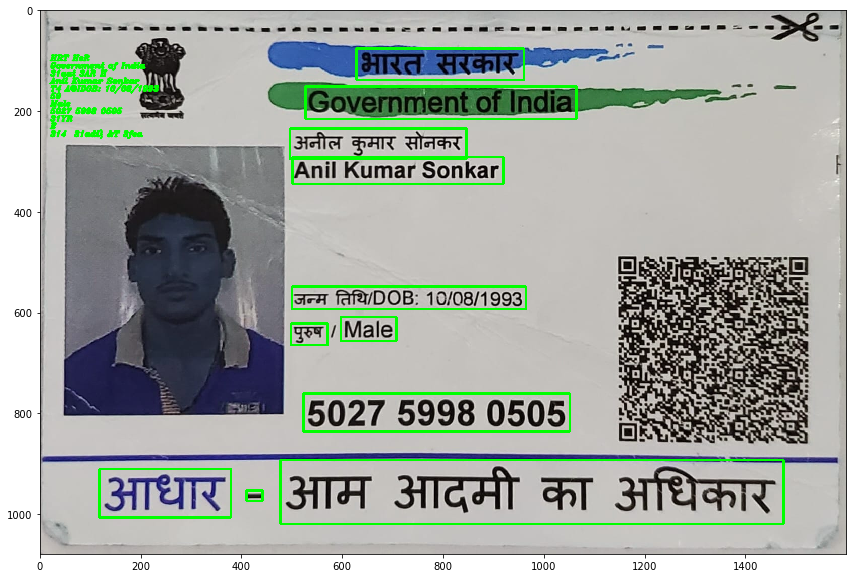

In [23]:
plt.figure(figsize=(25,10))
plt.imshow(img)
plt.show()

# custom model : train your own ocr model https://github.com/JaidedAI/EasyOCR/blob/master/custom_model.md

# azure form recognizer end point API 

In [24]:
now = datetime.datetime.now()
currentDatePath =  format('%02d' % now.year)+ format('%02d' % now.month)+ format('%02d' % now.day)
configFileName = 'ConnectionParametersOCR.config'
# thisfolder = os.path.dirname(os.path.abspath(__file__))
# configfile = os.path.join(thisfolder,configFileName)
configParser = configparser.RawConfigParser()#object definition 
configParser.read(configFileName)
file_path = ".\\dbdata\\"
STORAGEACCOUNTNAME = ast.literal_eval(configParser.get('my-config','blobaccount'))
STORAGEACCOUNTKEY = ast.literal_eval(configParser.get('my-config','blobsacc_key'))
dump_container_path  = ast.literal_eval(configParser.get('my-config','dump_container_name'))
cog_api_end_point  = ast.literal_eval(configParser.get('my-config','cog_api_end_point'))
cogn_api_key  = ast.literal_eval(configParser.get('my-config','cogn_api_key'))
blob_sas_url  = ast.literal_eval(configParser.get('my-config','blob_sas_url_test'))

URL ="https://image.shutterstock.com/shutterstock/photos/770028079/display_1500/stock-photo-this-is-a-generic-mock-health-insurance-card-from-an-employer-sponsored-health-care-plan-770028079.jpg"

In [28]:
STORAGEACCOUNTNAME

'cisasandbox'

In [25]:
def teams_message_channel(text_mess,web_hook_URL):
    myTeamsMessage = pymsteams.connectorcard(web_hook_URL,verify=False)
    myTeamsMessage.text(text_mess)
    #send the message to the teams
    myTeamsMessage.send()

In [26]:
def read_files_blob_storage(container_name,blob_name,STORAGEACCOUNTNAME,STORAGEACCOUNTKEY):
    try:
        block_blob_service = BlockBlobService(account_name=STORAGEACCOUNTNAME, account_key=STORAGEACCOUNTKEY)
        #print(block_blob_service)
        blob  = block_blob_service.get_blob_to_bytes(container_name, blob_name)
        data = blob.content
        content_type = blob.properties.content_settings.content_type
        #print("read data successfully")
        return data,content_type
    except Exception as e:
        print("Error in Reading blob :{}".format(e))
        return "Error in Reading blob :"+str(e)

In [31]:
#read_files_blob_storage('cisadevblobforocr', 'Capture.JPG',STORAGEACCOUNTNAME,STORAGEACCOUNTKEY)

In [27]:
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential
import os
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.formrecognizer import FormTrainingClient


endpoint =cog_api_end_point
credential = AzureKeyCredential(cogn_api_key)


form_recognizer_client = FormRecognizerClient(endpoint, credential)

with open(IMAGE_PATH, "rb") as fd:
    receipt = fd.read()
poller = form_recognizer_client.begin_recognize_invoices (receipt)
#poller = form_recognizer_client.begin_recognize_receipts_from_url(receipt_url=URL)
result = poller.result()

for receipt in result:
    for name, field in receipt.fields.items():
        if name == "Items":
            print("Receipt Items:")
            for idx, items in enumerate(field.value):
                print("...Item #{}".format(idx+1))
                for item_name, item in items.value.items():
                    print("......{}: {} has confidence {}".format(item_name, item.value, item.confidence))
        else:
            print("{}: {} has confidence {}".format(name, field.value, field.confidence))

InvoiceDate: 1993-10-08 has confidence 0.62
VendorName: Government of India has confidence 0.989


# Custom based training model 

In [28]:
form_recognizer_client = FormRecognizerClient(endpoint, credential)
form_training_client = FormTrainingClient(endpoint, credential)

In [29]:
# To train a model you need an Azure Storage account.
# Use the SAS URL to access your training files.
trainingDataUrl = blob_sas_url
#"PASTE_YOUR_SAS_URL_OF_YOUR_FORM_FOLDER_IN_BLOB_STORAGE_HERE"

poller = form_training_client.begin_training(trainingDataUrl, use_training_labels=False)
model = poller.result()

print("Model ID: {}".format(model.model_id))
print("Status: {}".format(model.status))
print("Training started on: {}".format(model.training_started_on))
print("Training completed on: {}".format(model.training_completed_on))

print("\nRecognized fields:")
for submodel in model.submodels:
    print(
        "The submodel with form type '{}' has recognized the following fields: {}".format(
            submodel.form_type,
            ", ".join(
                [
                    field.label if field.label else name
                    for name, field in submodel.fields.items()
                ]
            ),
        )
    )

# Training result information
for doc in model.training_documents:
    print("Document name: {}".format(doc.name))
    print("Document status: {}".format(doc.status))
    print("Document page count: {}".format(doc.page_count))
    print("Document errors: {}".format(doc.errors))

Model ID: 44a8badf-d6fd-4a4e-be67-c229b1c595b4
Status: ready
Training started on: 2022-05-01 07:52:55+00:00
Training completed on: 2022-05-01 07:53:13+00:00

Recognized fields:
The submodel with form type 'form-0' has recognized the following fields: $50 Spec:, Copays:, ER:, Group Number:, Health Plan (80840), Member ID:, Member:, OPTUMRx, Office:, PCP Phone:, PCP:, Rx Bin:, Rx Grp:, Rx PCN:, Spec:, UnitedHealthcare, UrgCare:
The submodel with form type 'form-1' has recognized the following fields: Date Issued:, Group No:, RxBin/Group:
The submodel with form type 'form-2' has recognized the following fields: Copay:, Group Number:, Member ID:, Rx Bin:, Rx Grp:
The submodel with form type 'form-3' has recognized the following fields: 
The submodel with form type 'form-4' has recognized the following fields: Coverage:, ID #:, Member:, Plan:, Rx BIN# :, Subscriber:
The submodel with form type 'form-5' has recognized the following fields: Group Number:, Member ID:, Office:, Rx Bin:, Rx Grp:

# Analyze forms with a custom model

In [35]:
trained_model_id =model.model_id
formUrl = 'http://3.bp.blogspot.com/-4wJNh3b1a2k/Tpjf__A5vWI/AAAAAAAAADU/GU9PX08M0qA/s1600/UnitedCardFront-1.jpg'
poller = form_recognizer_client.begin_recognize_custom_forms_from_url(model_id=trained_model_id, form_url=formUrl)
result = poller.result()

for recognized_form in result:
    print("Form type: {}".format(recognized_form.form_type))
    for name, field in recognized_form.fields.items():
        print("Field '{}' has label '{}' with value '{}' and a confidence score of {}".format(
            name,
            field.label_data.text if field.label_data else name,
            field.value,
            field.confidence
        ))

Form type: None
Field 'field-0' has label 'Member ID:' with value '999999876' and a confidence score of 1.0
Field 'field-1' has label 'Group Number:' with value '987654' and a confidence score of 1.0
Field 'field-2' has label 'Rx Bin:' with value '610014' and a confidence score of 1.0
Field 'field-3' has label 'Rx Grp:' with value 'UHEALTH' and a confidence score of 1.0
Field 'field-4' has label 'Copay:' with value 'Office / Spec / ER / URG' and a confidence score of 1.0


# usig local form

In [30]:
local_path ="C:\\OCR_PROJECT\\ImageData\\card_1.JPG"

In [31]:
local_form = open(local_path,'rb')#'PIOTR STASIAK'

In [32]:
trained_model_id =model.model_id
poller = form_recognizer_client.begin_recognize_custom_forms(model_id=trained_model_id,form=local_form,content_type ='image/png')
result = poller.result()

for recognized_form in result:
    print("Form type: {}".format(recognized_form.form_type))
    for name, field in recognized_form.fields.items():
        print("Field '{}' has label '{}' with value '{}' and a confidence score of {}".format(
            name,
            field.label_data.text if field.label_data else name,
            field.value,
            field.confidence
        ))

Form type: form-6
Field 'field-0' has label 'Health Plan (80840)' with value '911-87726-04' and a confidence score of 1.0
Field 'field-1' has label 'Member ID:' with value '933194893' and a confidence score of 1.0
Field 'field-2' has label 'Group Number:' with value '0Q5596' and a confidence score of 1.0
Field 'field-3' has label 'Member:' with value 'COLLABORATIVE IMAGING' and a confidence score of 1.0
Field 'field-4' has label 'PIOTR STASIAK' with value 'Eff Dt 03/01/2021' and a confidence score of 1.0
Field 'field-5' has label 'Rx Bin:' with value '610279' and a confidence score of 1.0
Field 'field-6' has label 'Rx PCN:' with value '9999' and a confidence score of 1.0
Field 'field-7' has label 'Office:' with value '$25' and a confidence score of 1.0
Field 'field-8' has label 'Tier 1 Office:' with value '$25' and a confidence score of 1.0
Field 'field-9' has label 'UrgCare:' with value '$75' and a confidence score of 1.0
Field 'field-10' has label 'Spec:' with value '$50' and a confi

# analyze form using blob data as input file

In [33]:
container_name,blob_name = 'cisadevblobforocr-test','card_1.JPG'
blob,content_type = read_files_blob_storage(container_name,blob_name,STORAGEACCOUNTNAME,STORAGEACCOUNTKEY)
trained_model_id =model.model_id

poller = form_recognizer_client.begin_recognize_custom_forms(model_id=trained_model_id,form=blob,content_type =content_type)
result = poller.result()

for recognized_form in result:
    print("Form type: {}".format(recognized_form.form_type))
    for name, field in recognized_form.fields.items():
        print("Field '{}' has label '{}' with value '{}' and a confidence score of {}".format(
            name,
            field.label_data.text if field.label_data else name,
            field.value,
            field.confidence
        ))

Form type: form-6
Field 'field-0' has label 'Health Plan (80840)' with value '911-87726-04' and a confidence score of 1.0
Field 'field-1' has label 'Member ID:' with value '933194893' and a confidence score of 1.0
Field 'field-2' has label 'Group Number:' with value '0Q5596' and a confidence score of 1.0
Field 'field-3' has label 'Member:' with value 'COLLABORATIVE IMAGING' and a confidence score of 1.0
Field 'field-4' has label 'PIOTR STASIAK' with value 'Eff Dt 03/01/2021' and a confidence score of 1.0
Field 'field-5' has label 'Rx Bin:' with value '610279' and a confidence score of 1.0
Field 'field-6' has label 'Rx PCN:' with value '9999' and a confidence score of 1.0
Field 'field-7' has label 'Office:' with value '$25' and a confidence score of 1.0
Field 'field-8' has label 'Tier 1 Office:' with value '$25' and a confidence score of 1.0
Field 'field-9' has label 'UrgCare:' with value '$75' and a confidence score of 1.0
Field 'field-10' has label 'Spec:' with value '$50' and a confi

In [34]:

os_path = "C:\\OCR_PROJECT\\ImageData\\CardImage\\"
#Import Library
import qrcode
#Generate QR Code
img=qrcode.make('https://stackoverflow.com/questions/22567306/how-to-upload-file-with-python-requests')
img.save(os_path+'hello.png')

# store data to SQL server Google cloud Platform

In [23]:
dbdetails_app = {  "server" : '34.131.211.214',
                    "database" : 'bill_book_data',
                    "username" : 'sqlserver',
                    "password" : 'Lcssarps@8log'
                        }

public_ip_address= "34.131.211.214"

In [24]:
def connect_sqldb(dbdetails):#using pyodbc driver need to setup in windows for sql server
    #try: 
    details = dbdetails#sfconfig_1.dbdetails#
    connect_string = 'DRIVER=ODBC Driver 17 for SQL Server;SERVER={server}; DATABASE={database};UID={username}\
                        ;PWD={password};Encrypt=YES;TrustServerCertificate=YES'.format(**details)

    connection = pyodbc.connect(connect_string)#connecting to the server
    print("sql connected successfully :")
    connection_url=URL.create("mssql+pyodbc", query={"odbc_connect": connect_string})
    connection_engine = create_engine(connection_url,fast_executemany=True)
    return connection,connection_engine

In [88]:
connection,connection_engine = connect_sqldb(dbdetails_app)

sql connected successfully :


In [87]:
def insert_df_to_sql(db_table_name,engine,batch,df_data):
    try:
        i=0#start
        k=batch #batch size
        while i*k<df_data.shape[0]:
            end=min((i+1)*k,df_data.shape[0])
            sub_res=df_data[i*k:end]
            sub_res.to_sql(db_table_name, con=engine, if_exists='append', index=False)
            print("done for -->",end)
            i=i+1
        return True
    except Exception as e:
        error_mess = "Error in insert for batch {}--->{}".format(i,str(e))
        #print(error_mess)
    return error_mess

In [46]:
df_book = pd.read_csv("Bill_Book_Soft_data.csv")

In [47]:
df_book.columns

Index(['GRC_no', 'Name', 'Address', 'Nationality', 'Arrv_From', 'Destination',
       'Mobile_no', 'ID_Proof', 'ID_no', 'Arrv_Date', 'Time', 'Room_no',
       'Rate', 'Plan', 'Tax_Inc', 'no_of_Person', 'Remark', 'User',
       'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name'],
      dtype='object')

In [54]:
df_book.Category_Name

0       BUDHA COTTAGE DELUX
1       BUDHA COTTAGE DELUX
2    BUDHA COTTAGE SUPERIOR
3        EXECUTIVE SUPERIOR
Name: Category_Name, dtype: object

In [62]:
#connection,connection_engine = connect_sqldb(dbdetails_app)#dont uncomment it
insert_df_to_sql('tbl_hotel_room_allocation',connection_engine,1500,df_book)

done for --> 4


True

In [1]:
trends = [1,2,1,3,4,2,4,3]
output = []
for x in trends:
    if x not in output:
        output.append(x)
print(output)

[1, 2, 3, 4]


# covert pdf table to excel data 

In [27]:
path_to_file = "C:\\OCR_PROJECT\\ImageData\\billbookSoft\\"+"room report 1-3-22 to 31-03-22.pdf"
path_to_file

'C:\\OCR_PROJECT\\ImageData\\billbookSoft\\room report 1-3-22 to 31-03-22.pdf'

In [28]:
from tabula.io import read_pdf
  
# Read PDF File
# this contain a list
df = read_pdf(path_to_file, pages = 1)[0]
  
# Convert into Excel File
df.to_csv('room_report.csv')

In [58]:
df_room_report = pd.read_csv("C:\\OCR_PROJECT\\ImageData\\billbookSoft\\room_report_data.csv")

In [97]:
df_room_report["Mobile No."] = df_room_report["Mobile No."].astype(float).astype('Int64')
df_room_report['GRC No.'] = df_room_report['GRC No.'].astype(float).astype('Int64')
df_room_report['Tax  No. of Inc. Person'].iloc[1]

'No                2'

In [98]:
df_room_report['GRC No.']

0        1
1        2
2        3
3     <NA>
4        4
      ... 
76    <NA>
77    <NA>
78    <NA>
79    <NA>
80    <NA>
Name: GRC No., Length: 81, dtype: Int64

In [72]:
def process_text_cols(text_col):
    text_col = str(text_col)
    text_list = text_col.split(" ")
    return text_list[0],text_list[-1]

In [73]:
process_text_cols(a)

('No', '2')

In [99]:
df_room_report['Category_Name'] = "BUDHA COTTAGE DELUX"
df_room_report['Rate_plan']  = df_room_report['Plan']
df_room_report['Pax']  = 2
df_room_report['Hotel_Name'] = 'BUDDHA THEME PARK'
df_room_report['Tax_Inc']  = df_room_report.apply(lambda x: process_text_cols(x['Tax  No. of Inc. Person'])[0],axis=1)
df_room_report['no_of_Person']  = df_room_report.apply(lambda x: process_text_cols(x['Tax  No. of Inc. Person'])[1],axis=1)


In [100]:
df_room_report['no_of_Person'][0]

'3'

In [101]:
df_room_report.columns

Index(['GRC No.', 'Name', 'Address', 'Nationality', 'Arriv. From',
       'Destination', 'Mobile No.', 'ID Proof', 'ID No.', 'Arriv.Date', 'Time',
       'Room No.', 'Rate', 'Plan', 'Tax  No. of Inc. Person', 'Remark', 'User',
       'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name', 'Tax_Inc',
       'no_of_Person'],
      dtype='object')

In [102]:
col_to_use =['GRC No.', 'Name', 'Address', 'Nationality', 'Arriv. From',
            'Destination', 'Mobile No.', 'ID Proof', 'ID No.', 'Arriv.Date', 'Time',
             'Room No.', 'Rate', 'Plan','Tax_Inc','no_of_Person', 'Remark', 'User',
             'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name']

cols = ['GRC_no', 'Name', 'Address', 'Nationality', 'Arrv_From', 'Destination',
       'Mobile_no', 'ID_Proof', 'ID_no', 'Arrv_Date', 'Time', 'Room_no',
       'Rate', 'Plan', 'Tax_Inc', 'no_of_Person', 'Remark', 'User',
       'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name']
len(col_to_use)

22

In [103]:
df_room_report_ = df_room_report[col_to_use]

df_room_report_.columns = cols

In [104]:
df_room_report_.columns

Index(['GRC_no', 'Name', 'Address', 'Nationality', 'Arrv_From', 'Destination',
       'Mobile_no', 'ID_Proof', 'ID_no', 'Arrv_Date', 'Time', 'Room_no',
       'Rate', 'Plan', 'Tax_Inc', 'no_of_Person', 'Remark', 'User',
       'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name'],
      dtype='object')

In [105]:
df_book.columns

Index(['GRC_no', 'Name', 'Address', 'Nationality', 'Arrv_From', 'Destination',
       'Mobile_no', 'ID_Proof', 'ID_no', 'Arrv_Date', 'Time', 'Room_no',
       'Rate', 'Plan', 'Tax_Inc', 'no_of_Person', 'Remark', 'User',
       'Category_Name', 'Rate_plan', 'Pax', 'Hotel_Name'],
      dtype='object')

In [108]:
df_room_report_.iloc[0]

GRC_no                             1
Name                  ARUNESH PRATAP
Address                      ISRAULI
Nationality                   Indian
Arrv_From                  GORAKHPUR
Destination                GORAKHPUR
Mobile_no                 9415328312
ID_Proof                 Aadhar Card
ID_no                    27857623140
Arrv_Date                  05-Mar-22
Time                           20:50
Room_no                         2002
Rate                            2300
Plan                           EPBCD
Tax_Inc                          Yes
no_of_Person                       3
Remark                           NaN
User                              GM
Category_Name    BUDHA COTTAGE DELUX
Rate_plan                      EPBCD
Pax                                2
Hotel_Name         BUDDHA THEME PARK
Name: 0, dtype: object

In [118]:
df_room_r = pd.read_csv("C:\\OCR_PROJECT\\ImageData\\billbookSoft\\room_report_data_1.csv")

In [119]:
df_room_r.iloc[0]

GRC_no                             1
Name                  ARUNESH PRATAP
Address                      ISRAULI
Nationality                   Indian
Arrv_From                  GORAKHPUR
Destination                GORAKHPUR
Mobile_no                9.41533e+09
ID_Proof                 Aadhar Card
ID_no                    27857623140
Arrv_Date                  05-Mar-22
Time                           20:50
Room_no                         2002
Rate                            2300
Plan                           EPBCD
Tax_Inc                          Yes
no_of_Person                       3
Remark                           NaN
User                              GM
Category_Name    BUDHA COTTAGE DELUX
Rate_plan                      EPBCD
Pax                                2
Hotel_Name         BUDDHA THEME PARK
Name: 0, dtype: object

In [120]:
insert_df_to_sql('tbl_hotel_room_allocation',connection_engine,1500,df_room_r)

done for --> 81


True